In [1]:
### Notebook contains code to temporarily move E3SM data to local, 
### run regridding, then move regridded version back to S3. 
### Needs some work..

## Alistair Duffey, Feb 26


In [1]:
## packages for cloud data intake: 
import s3fs
import fsspec

## packages for analysis
import pandas as pd
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import os
import boto3
import xarray as xr
from urllib.parse import urlparse

In [2]:
## needs a lot of memory (~ 8GB) 
## also takes a little while 
%conda install -c conda-forge nco

Channels:
 - conda-forge
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: / 


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - nco


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gsl-2.7                    |       he838d99_0         3.2 MB  conda-forge
    libudunits2-2.2.28         |       h40f5838_3          80 KB  conda-forge
    nco-5.3.3                  |       h657489c_0         1.8 MB  conda-forge
    openssl-3.6.1              |       h35e630c_1         3.0 MB  conda-forge
    tempest-remap-2.2.0        |       heeae502_5         965 KB  conda-forge
    -----------------------------------------------

In [ ]:
### code below downloads files to local form bucket, and regirds them to local 

In [4]:
import os
import boto3
import xarray as xr
import subprocess
from urllib.parse import urlparse

# --- CONFIGURATION ---
hilla_paths = [
    's3://reflective-persistent-prod-large/E3SMv3/G6-1.5K-HiLLA/v3.LR.ssp245.g6_hilla.sai.0101/Amon/TREFHT/gn/13112025/',
    's3://reflective-persistent-prod-large/E3SMv3/G6-1.5K-HiLLA/v3.LR.ssp245.g6_hilla.sai.0151/Amon/TREFHT/gn/13112025/',
    's3://reflective-persistent-prod-large/E3SMv3/G6-1.5K-HiLLA/v3.LR.ssp245.g6_hilla.sai.0201/Amon/TREFHT/gn/13112025/'
     's3://reflective-persistent-prod-large/E3SMv3/G6-1.5K-HiLLA/v3.LR.ssp245_0101/Amon/TREFHT/gn/13112025/',
    's3://reflective-persistent-prod-large/E3SMv3/G6-1.5K-HiLLA/v3.LR.ssp245_0151/Amon/TREFHT/gn/13112025/',
    's3://reflective-persistent-prod-large/E3SMv3/G6-1.5K-HiLLA/v3.LR.ssp245_0201/Amon/TREFHT/gn/13112025/',
]

# Path to your mapping file (ne30 to lat/lon)
MAP_FILE = "../shared/Data/E3SM_maps/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc"
LOCAL_BASE_DIR = './hilla_regridded'

s3 = boto3.client('s3')
os.makedirs(LOCAL_BASE_DIR, exist_ok=True)

def run_ncremap(input_path, output_path, map_file):
    """Executes the shell command for ncremap."""
    cmd = ["ncremap", "-i", input_path, "-m", map_file, "-o", output_path]
    try:
        subprocess.run(cmd, check=True, capture_output=True, text=True)
        return True
    except subprocess.CalledProcessError as e:
        print(f"Error regridding {input_path}: {e.stderr}")
        return False

# --- MAIN EXECUTION ---
all_datasets = []

for s3_url in hilla_paths:
    parsed = urlparse(s3_url)
    bucket = parsed.netloc
    prefix = parsed.path.lstrip('/')
    
    # Identify the specific ensemble/simulation name
    set_name = prefix.split('/')[2] 
    raw_dir = os.path.join(LOCAL_BASE_DIR, set_name, 'raw')
    regrid_dir = os.path.join(LOCAL_BASE_DIR, set_name, 'regridded')
    os.makedirs(raw_dir, exist_ok=True)
    os.makedirs(regrid_dir, exist_ok=True)

    print(f"\n>>> Processing ensemble: {set_name}")
    
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    if 'Contents' not in response:
        continue

    for obj in response['Contents']:
        key = obj['Key']
        if not key.endswith('.nc'): continue
        
        filename = os.path.basename(key)
        local_raw = os.path.join(raw_dir, filename)
        local_regrid = os.path.join(regrid_dir, f"regridded_{filename}")

        # 1. Download
        print(f"  Downloading: {filename}")
        s3.download_file(bucket, key, local_raw)

        # 2. Regrid
        print(f"  Regridding: {filename}")
        success = run_ncremap(local_raw, local_regrid, MAP_FILE)
        
        # Optional: Remove raw file to save space
        if success:
            os.remove(local_raw)

    # 3. Load the regridded set into Xarray
    # We open all files in the regridded folder for this specific set
    ds = xr.open_mfdataset(f"{regrid_dir}/*.nc", combine='by_coords')
    all_datasets.append(ds)

print("\nAll sets processed and loaded into 'all_datasets' list.")


>>> Processing ensemble: v3.LR.ssp245_0101
  Downloading: TREFHT_201501_201912.nc
  Regridding: TREFHT_201501_201912.nc
  Downloading: TREFHT_202001_202412.nc
  Regridding: TREFHT_202001_202412.nc
  Downloading: TREFHT_202501_202912.nc
  Regridding: TREFHT_202501_202912.nc
  Downloading: TREFHT_203001_203412.nc
  Regridding: TREFHT_203001_203412.nc
  Downloading: TREFHT_203501_203912.nc
  Regridding: TREFHT_203501_203912.nc
  Downloading: TREFHT_204001_204412.nc
  Regridding: TREFHT_204001_204412.nc
  Downloading: TREFHT_204501_204912.nc
  Regridding: TREFHT_204501_204912.nc
  Downloading: TREFHT_205001_205412.nc
  Regridding: TREFHT_205001_205412.nc
  Downloading: TREFHT_205501_205912.nc
  Regridding: TREFHT_205501_205912.nc
  Downloading: TREFHT_206001_206412.nc
  Regridding: TREFHT_206001_206412.nc
  Downloading: TREFHT_206501_206912.nc
  Regridding: TREFHT_206501_206912.nc
  Downloading: TREFHT_207001_207412.nc
  Regridding: TREFHT_207001_207412.nc
  Downloading: TREFHT_207501_207

In [ ]:
## above code saves a local temp copy, regrids to a second local temp copy
## below reads in all those regridded temp copies, and writes to a single netcdf file

In [15]:
dirs = os.listdir('hilla_regridded/')

for run in dirs:
    print(run)
    filename = os.listdir('hilla_regridded/{}/regridded/'.format(run))[0]
    print(filename)
    out_path = 'hilla_regridded/{r}/regridded_combined/'.format(r=run)
    os.makedirs(out_path, exist_ok=True)
    ds = xr.open_mfdataset('hilla_regridded/{}/regridded/*.nc'.format(run))
    ds.to_netcdf(out_path + filename)
    print('local combined copy written')
    
    ## then put the file on the s3 bucket too: 
    # out path on bucket:
    DEST_BUCKET = 'reflective-persistent-prod'
    dest_key = 'alistairduffey/E3SMv3/regridded_combined/{r}/{f}'.format(r=run, f=filename)

    s3.upload_file(out_path + filename, DEST_BUCKET, dest_key)

    print('uploaded combined to S3')

v3.LR.ssp245.g6_hilla.sai.0101
regridded_TREFHT_203501_203912.nc
local combined copy written
uploaded combined to S3
v3.LR.ssp245.g6_hilla.sai.0151
regridded_TREFHT_203501_203912.nc
local combined copy written
uploaded combined to S3
v3.LR.ssp245.g6_hilla.sai.0201
regridded_TREFHT_203501_203912.nc
local combined copy written
uploaded combined to S3
v3.LR.ssp245_0101
regridded_TREFHT_201501_201912.nc
local combined copy written
uploaded combined to S3
v3.LR.ssp245_0151
regridded_TREFHT_201501_201912.nc
local combined copy written
uploaded combined to S3
v3.LR.ssp245_0201
regridded_TREFHT_201501_201912.nc
local combined copy written
uploaded combined to S3


In [16]:
## test reading in one of the combined regridded files on persistent-prod

s3_path = 's3://reflective-persistent-prod/'+dest_key
# Open the dataset directly from the S3 URL using xarray
with fsspec.open(s3_path, mode='rb') as file:
    ds = xr.open_dataset(file, engine="h5netcdf", chunks={}).load()

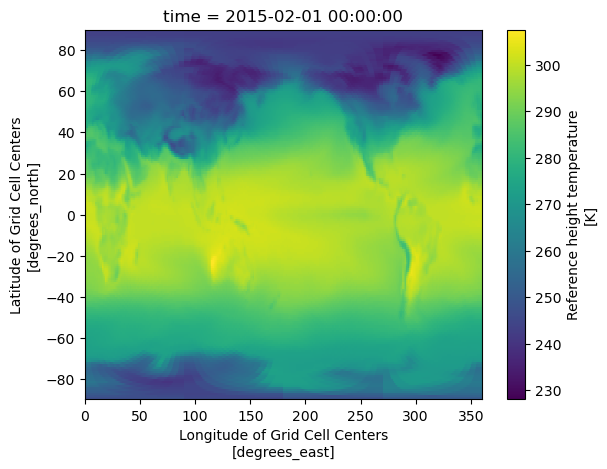

In [18]:
ds.TREFHT.isel(time=0).plot()